In [1]:
using Revise
using DrWatson
using CUDA
using MLUtils
using Flux
using Plots
using DSP
using Statistics
#using GR
using ProgressMeter

include("symae.jl")
println("Packages are loaded")

gr()
xpu = gpu

CUDA.device!(7)

function toy_green!(x)
    nt = size(x, 1)
    nr = size(x, 2)
    for ir = 1:nr
        for it in randobs(30:nt-30, 2)
            x[it, ir] = randn()
        end
    end
    return x
end

##
ntc = 200
nt = 256
@show nsamp_train = 3000
@show nsamp_test = 100
##

##
mp(x, s = "") = plot(cpu(x), size = (800, 200), label = nothing, w = 2, title = s)
##

##
g1 = zeros(nt, nsamp_train)
toy_green!(g1)
g1train, g1test = splitobs(g1, at = 0.9)
g2 = zeros(nt, nsamp_train)
toy_green!(g2)
g2train, g2test = splitobs(g2, at = 0.9)
gnew = zeros(nt, nsamp_test)
toy_green!(gnew)
mp(randobs(g1, 10), "randomly picked filters")
##

##
function multiconv(g, s)
    g = cat(g, dims = 3)
    g = permutedims(g, [1, 3, 2])
    s = cat(s, dims = 3)
    d = Flux.conv(g, s, groups = size(g, 2), pad = size(s, 1), flipped = false)
    d = permutedims(d, [1, 3, 2])
    d = dropdims(d, dims = 3)
    return Float32.(d[2:size(g, 1)+1, :])
end
##

##
# generate sources
s1 = DSP.Windows.triang(10)
s1 = randn(10)
s1 = Flux.normalise(s1)
s2 = DSP.Windows.hanning(20)
s2 = randn(20)
s2 = Flux.normalise(s2)
s3 = Flux.normalise(s2)
snew = randn(10)
mp([s1, s2], "sources")
##

##
d1 = multiconv(g1train, s1) |> xpu
d2 = multiconv(g2train, s2) |> xpu
d12 = multiconv(g2train, s1)
d21 = multiconv(g1train, s2)
dnew = multiconv(gnew, snew) |> xpu

d1 = Flux.normalise(d1, dims = 1)
d2 = Flux.normalise(d2, dims = 1)
d12 = Flux.normalise(d12, dims = 1)
d21 = Flux.normalise(d21, dims = 1)
dnew = Flux.normalise(dnew, dims = 1)

d1test = multiconv(g1test, s1) |> xpu
d2test = multiconv(g2test, s2) |> xpu
d1test = Flux.normalise(d1test, dims = 1)
d2test = Flux.normalise(d2test, dims = 1)

mp(cpu(d1[:, randobs(1:nsamp_train)]), "randomly picked instances")
plot!(cpu(d2[:, randobs(1:nsamp_train)]), w = 2)

begin
    @show p = 50
    @show q = 50
end

begin
    opt = ADAM(0.001)
    nepoch = 100
    trainloss = []
    testloss = []
    X = get_data_iterator([d1, d2])
    nothing
end

##

# senc1, senc2, nenc, dec = get_dense_networks(nt, p, q)
NN = get_conv_networks(nt, p, q)
sencb = BroadcastSenc(NN["senc1"], NN["senc2"])
nencb = BroadcastNenc(NN["nenc"])
decb = BroadcastDec(NN["dec"])
encb = JoinEncs(sencb, nencb)
model(x) = decb(encb(x))
##

NN["senc1"]
NN["senc2"]

# ╔═╡ 00cb1dac-1eab-45bc-b7f6-628aca7ed9d3
NN["nenc"]

# ╔═╡ 6c72db77-d31d-4c22-a522-590a77e23425
NN["dec"]

# ╔═╡ 9a90ca61-aafb-4ee9-9570-db15991fe46d
function update_losses(trainloss, testloss)
    map!(x->Flux.trainmode!(x, false), values(NN))
    map!(x->Flux.testmode!(x, true), values(NN))
    dd1 = randobs(d1, numobs(d1test))
    dd2 = randobs(d2, numobs(d2test))
    l1 = Flux.mse(cat(model(dd1), model(dd2), dims = 2), cat(dd1, dd2, dims = 2))
    l2 =
        Flux.mse(cat(model(d1test), model(d2test), dims = 2), cat(d1test, d2test, dims = 2))
    push!(trainloss, l1)
    push!(testloss, l2)
    return l1, l2
end

# ╔═╡ 424fe621-4f2e-4678-adb8-47f77916d7b3
function update_senc(nepoch)
    ps = Flux.params(sencb, decb)
    @showprogress for epoch = 1:nepoch
        for x in X
            gs = Flux.gradient(() -> Flux.mse(model(x), x), ps) # compute gradient
            Flux.Optimise.update!(opt, ps, gs) # update ameters
        end
        update_losses(trainloss, testloss)
    end
end

# ╔═╡ c962835e-ed84-4ff3-8304-f638d656eb91
function update_nenc(nepoch)
    p = Progress(nepoch, showspeed = true)
    ps = Flux.params(values(NN)...)
    for epoch = 1:nepoch
        map!(x->Flux.trainmode!(x, true), values(NN))
        map!(x->Flux.testmode!(x, false), values(NN))
        for x in X
            gs = Flux.gradient(() -> Flux.mse(model(x), x), ps) # compute gradient
            Flux.Optimise.update!(opt, ps, gs) # update parameters
        end
        map!(x->Flux.trainmode!(x, false), values(NN))
        map!(x->Flux.testmode!(x, true), values(NN))
        ltrain, ltest = update_losses(trainloss, testloss)
        ProgressMeter.next!(
            p;
            showvalues = [(:epoch, epoch), (:train_loss, ltrain), (:test_loss, ltest)],
        )
    end
end

Packages are loaded
nsamp_train = 3000 = 3000
nsamp_test = 100 = 100
p = 50 = 50
q = 50 = 50


update_nenc (generic function with 1 method)

In [20]:
update_nenc(500)


┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /math/home/eruisun/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress: 100%|███████████████████████████| Time: 0:30:15 ( 3.63  s/it)
  epoch:       500
  train_loss:  0.06371611
  test_loss:   0.0738788


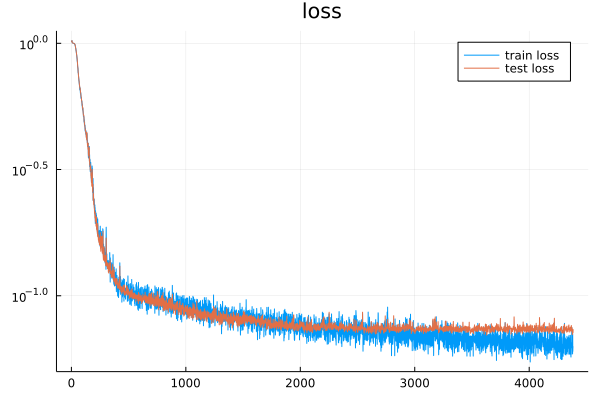

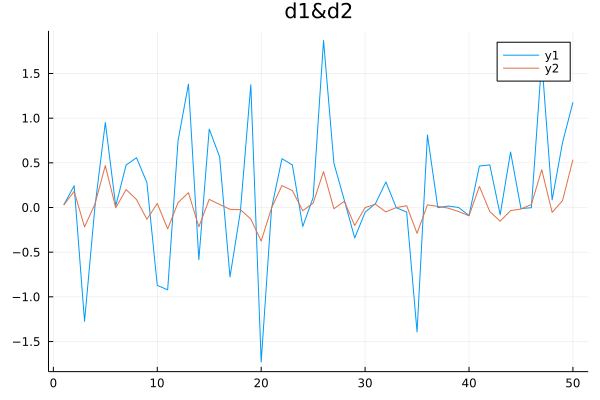

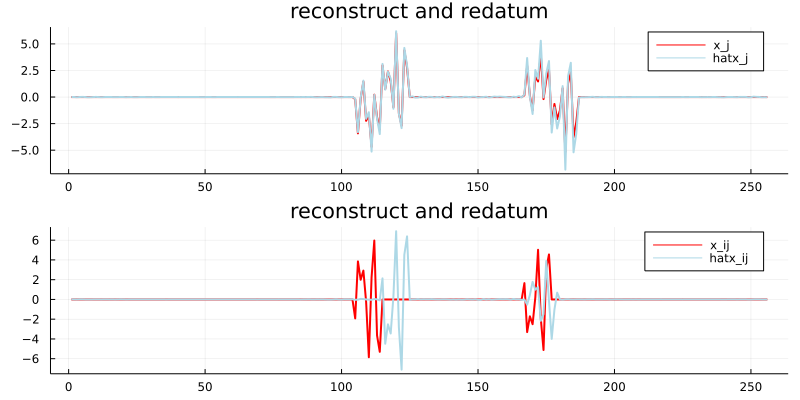

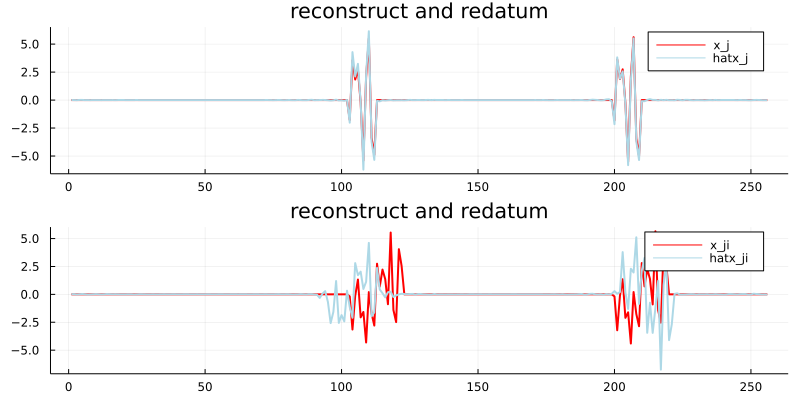

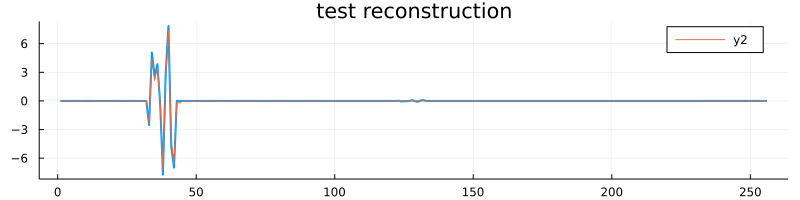

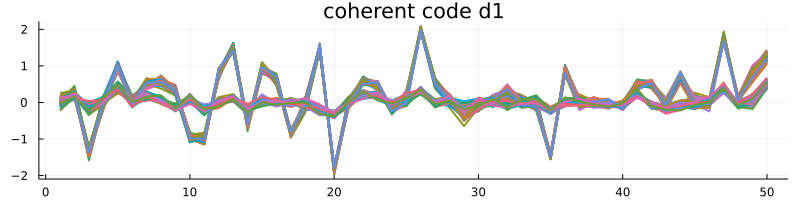

In [19]:
# ╔═╡ 42ccc5cb-5d56-4c17-b62a-574a9b95f78c
begin
    fig = plot(trainloss,yaxis = :log, label = "train loss", title="loss")
    plot!(testloss, yaxis = :log, label = "test loss")
    display(fig)
end

# ╔═╡ 41fda66b-611a-458f-82d3-5a491c12afa4
begin
    map!(x->Flux.trainmode!(x, false), values(NN))
    map!(x->Flux.testmode!(x, true), values(NN))
    zsym1 = sencb(d1)
    zsym2 = sencb(d2)
    d1hat = model(d1)
    d2hat = model(d2)
    d1testhat = model(d1test)
    d12hat = decb(cat(zsym1, nencb(d2), dims = 1))
    d12hat = Flux.normalise(d12hat, dims=1)
    d21hat = decb(cat(zsym2, nencb(d1), dims = 1))
    d21hat = Flux.normalise(d21hat, dims=1)
    nothing
end

# ╔═╡ 9f4c8ca2-f524-4b12-97f0-5d8c7fc46e12

begin
    fig = plot(cpu(sencb(d2))[:,1,1],title="d1&d2")
    plot!(cpu(sencb(d1))[:,1,1])
    display(fig)
end

iplt2 = randobs(1:numobs(d1))

# ╔═╡ c3e51085-7eb9-417d-ac93-63e1bfadc1e2
size(d2)
# nsamp_train

begin
    p1=plot(cpu(d2[:, iplt2]), c=:red, label = "x_j", )
    plot!(p1, cpu(d2hat[:, iplt2]), c=:lightblue,label = "hatx_j")
    p2=plot(cpu(d12[:, iplt2]), c=:red,label = "x_ij",)
    plot!(p2,cpu(d12hat[:, iplt2]), c=:lightblue,label = "hatx_ij")
    fig = plot(p1, p2, layout=(2,1), size = (800, 400), w=2, title="reconstruct and redatum")
    display(fig)
end

begin
    p1=plot(cpu(d1[:, iplt2]), c=:red, label = "x_j", )
    plot!(p1, cpu(d1hat[:, iplt2]), c=:lightblue, label = "hatx_j")
    p2=plot(cpu(d21[:, iplt2]), c=:red, label = "x_ji")
    plot!(p2,cpu(d21hat[:, iplt2]), c=:lightblue, label = "hatx_ji")
    fig = plot(p1, p2, layout=(2,1), size = (800, 400), w=2, title="reconstruct and redatum")
    display(fig)
end

iplt3 = randobs(1:numobs(d1test))

begin
    fig = plot(mp(d1test[:, iplt3]), title = "test reconstruction")
    plot!(cpu(d1testhat[:, iplt3]))
    display(fig)
    # plot!(cpu(d12hat[:, iplt]))
end

fig = plot(
    cpu(sencb(randobs(X)))[:, 1, :],
    label = nothing,
    w = 2,
    size = (800, 200),
    title = "coherent code d1",
)
display(fig)